<a href="https://colab.research.google.com/github/jacopomanenti01/Graph-Neural-Networks/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1

In this notebook, we will apply two kernel methods to design the graph features $\phi(G)$ and compute the similarity based on the feature vectors obtained.

Specifically, we will use two well-known kernel methods: the Graphlet Kernel and the Weisfeiler-Lehman Kernel, applying them to both synthetic and real-world graph datasets.

We will evaluate these algorithms by comparing the similarities they compute, as well as their efficiency in terms of time and memory consumption. Additionally, we will analyze their performance with respect to the number of nodes in the graphs and the number of iterations required.

First, we import some package we will be using in this notebook

In [1]:
# Upgrade packages
!pip install --upgrade scipy networkx
# Install torch geometric
!pip install torch torchvision torchaudio torch-geometric
# Others
!pip install wmi


# Import important libraries
import networkx as nx
import matplotlib.pyplot as plt
import webcolors
import torch
from tabulate import tabulate
import os
import psutil
from collections import Counter
import time
import numpy as np
import math



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 825.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 32.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4
    Uninstalling networkx-3.4:
      Successfully uninstalled networkx-3.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.8 MB/s eta 0:00:00
INFO: pip is looking at multiple 

Futhermore, we specify some utility functions:


1.   Update table: used to create a reporting table
2.   Profile: used to compute the memeory consumption



In [2]:
# Create a table for reporting algorithms' results
def update_table(values, header):
  table_structure = np.array(values)
  headers = header
  report_table = tabulate(table_structure, headers, tablefmt="fancy_grid")

  print(report_table)

In [3]:
def process_memory():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss

def profile(func):
    def wrapper(*args, **kwargs):
        mem_before = process_memory()
        result = func(*args, **kwargs)
        mem_after = process_memory()

        memory_consumed = mem_after - mem_before
        memory_mb = memory_consumed / 1024 / 1024  # Convert in MB


        return (*result, memory_mb)
    return wrapper

# Graph visualization and analysis

In this section, we import the graphs used for Task 1, specifically the ones to which we will apply the Graphlet algorithm.

We will import two small synthetic graph datasets (each with 100 nodes) and one large real-world graph dataset ($\sim 4,000$ nodes):



1.   Syntethic data:
  - **Barabási-Albert Graph**: A scale-free graph that models real-world networks with preferential attachment.

  - **Watts-Strogatz Small-World Graph**: A graph that captures small-world properties, balancing randomness and regularity.


2.   Real data:
  - **Facebook Social Circles Network**: This dataset consists of 'circles' (or 'friends lists') from Facebook. Facebook data was collected from survey participants using this Facebook app.




In [4]:

# Import Synthetic Graphs from nx
BA_Graph = nx.barabasi_albert_graph(100,2)
WSWS_Graph= nx.watts_strogatz_graph(100,2,0.5)

# Import Social circles: Facebook
FB_Graph =nx.read_edgelist("/content/facebook_combined.txt", create_using = nx.Graph(), nodetype=int)

Let's visualize them:

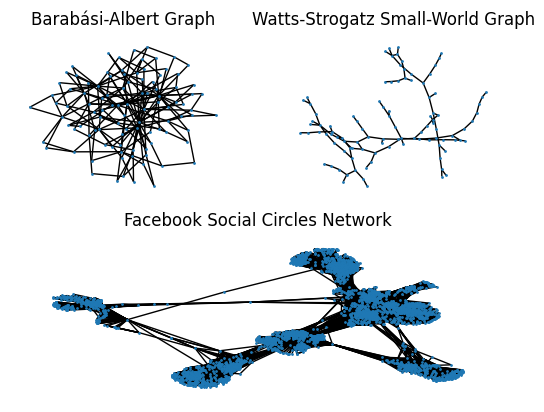

In [ ]:
import matplotlib.gridspec as gridspec

# Create 2x2 sub plots
fig = plt.figure()
gs = gridspec.GridSpec(2, 2, figure=fig)

# row 0, col 0
ax = plt.subplot(gs[0, 0])
ax.set_title("Barabási-Albert Graph")
nx.draw(BA_Graph, node_size=1)
# row 0, col 1
ax = plt.subplot(gs[0, 1])
ax.set_title("Watts-Strogatz Small-World Graph")
nx.draw(WSWS_Graph,node_size=1)
# row 1, span all columns
ax = plt.subplot(gs[1, :])
ax.set_title("Facebook Social Circles Network")
nx.draw(FB_Graph, node_size=1)

plt.show()




Let’s also analyze the **degree distribution** of the graphs.

In general, the degree $k$ of a node $v$ represents the number of edges (or neighboring nodes) that the node is connected to. This metric treats all neighboring nodes equally, providing a straightforward way to understand the connectivity of a graph.




In [ ]:
# Create a function to compute node degree
def degrees(G):
  degrees = [G.degree(i) for i in G.nodes()]
  return degrees



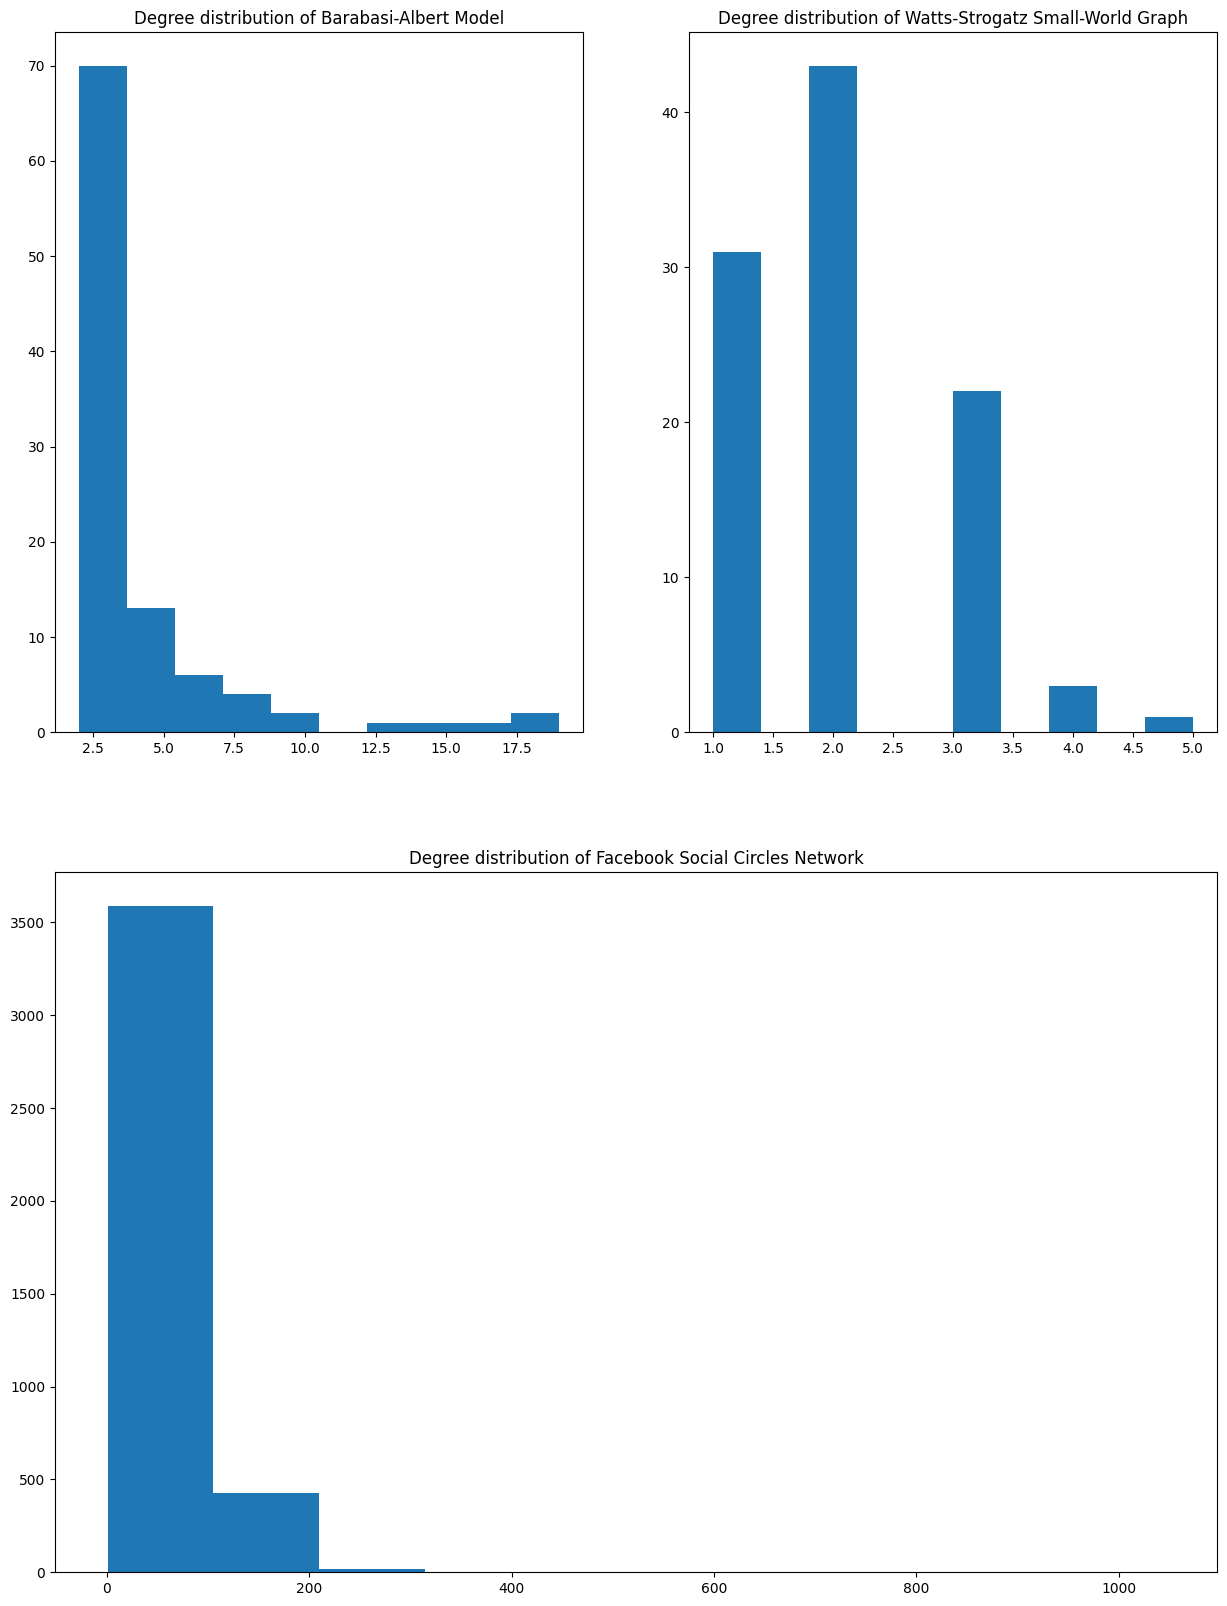

In [ ]:
fig = plt.figure(figsize=(15,20))

# row 0, col 0
ax = plt.subplot(gs[0,0])
ax.set_title("Degree distribution of Barabasi-Albert Model")
plt.hist(degrees(BA_Graph))

# row 0, col 1
ax = plt.subplot(gs[0,1])
ax.set_title("Degree distribution of Watts-Strogatz Small-World Graph")
plt.hist(degrees(WSWS_Graph))

# row 1, span all columns
ax = plt.subplot(gs[1,:])
ax.set_title("Degree distribution of Facebook Social Circles Network")
plt.hist(degrees(FB_Graph))
plt.show()




The degree distribution captures how node connectivity is spread throughout a graph, making it an important metric when comparing the structural properties of two graphs. If two graphs have similar degree distributions, it often suggests that they share comparable network structures or topologies.


# Task 1: Graphlet Kernel Implementation

We will now proceed to implement the Graphlet Kernel from scratch. Afterward, we will compare its efficiency—both in terms of memory and computation—and evaluate the similarity between this method and others. We will first apply the kernel to two small synthetic datasets we imported earlier: the Barabási-Albert Graph and the Watts-Strogatz Small-World Graph. Then, we will test it on a larger, real-world dataset, the Facebook Social Circles Network, comparing it against the synthetic datasets to observe how the results differ.

In the graphlet kernel approach, we first analyze the structure of a graph by counting the occurrences of small subgraphs, known as **graphlets**.

The nodes in a graphlet **do not need to be connected** and the graphlets are **not rooted**, meaning that their structure is analyzed without a designated starting point.



Given a graph $G$ and a graphlet list $G_k = (g_1,g_2,\dots,g_{n_K})$, i.e. a list that contains small connected subgraphs of k nodes,  where k is the number of nodes considered,  we define the graphlet count vector $f_G \in R^{n_k}$ as:


$$f_g = \#(g_i \subseteq G) \text{ for } i = 1,2, n_k$$


With this approach, we capture the structural information of a graph in a compact form.




Once we have computed the feature vector for each graph, we can apply the **Graph Kernel** to measure the similarity between the graphs based on the graphlets they hold.


Given two graphs, G and G' , graphlet kernel is computed as:

$$K(G,G^{'})=f_G^Tf_{G^{'}}$$

To assess the size missmatch,  we apply the kernel to the normalize  version of the feature vectors:


$$h_G=\frac{f_G}{sum(f_G)}$$

$$K(G,G^{'})=h_G^Th_{G^{'}}$$



Here is how we implemented the algorithm:

In [5]:
from itertools import combinations
import time


def count_graphlets_optimized(G, k):
    graphlets_count = {}
    nodes = list(G.nodes())
    n = len(nodes)

    # Pre-compute adjacency information
    adj_matrix = nx.to_numpy_array(G)

    # Use numpy operations for faster edge counting
    for vertices_idx in combinations(range(n), k):
        submatrix = adj_matrix[np.ix_(vertices_idx, vertices_idx)]
        edges = int(np.sum(submatrix) / 2)  # Divide by 2 since matrix is symmetric
        if edges not in graphlets_count:
          graphlets_count[edges] = 0
        graphlets_count[edges] += 1

    # Prepare the feature vector
    max_edges = (k * (k-1)) // 2
    feature_vector = np.zeros(max_edges + 1)
    for edges, count in graphlets_count.items():
        feature_vector[edges] = count

    return feature_vector, np.sum(feature_vector)

@profile
def graphlet_kernel(G1, G2, k):

  start_time = time.time()

  # Compute feature vectors
  feature_vector_g1, count_g1 = count_graphlets_optimized(G1, k)
  feature_vector_g2, count_g2 = count_graphlets_optimized(G2, k)

  # Normalize vectors before dot product
  feature_vector_g1_norm = feature_vector_g1 / count_g1
  feature_vector_g2_norm = feature_vector_g2 / count_g2

  # Compute kernel
  result = np.dot(feature_vector_g1_norm, feature_vector_g2_norm)

  # Compute and Format time execution
  end_time = time.time()
  time_execution = end_time - start_time
  return result, time_execution



Let's test the algorithm

In [8]:
# Set the number of iterations
iterations = 4

# Apply the algorithm on synthetic dataset
similarity, execution_time, memory_consumption = graphlet_kernel(BA_Graph,WSWS_Graph,iterations)

# Apply the algorithm on real and synthetic dataset
similarity2, execution_time2, memory_consumption2 = graphlet_kernel(FB_Graph,BA_Graph,iterations)

Let's show the results:

In [10]:
update_table([["Barabási-Albert Graph vs Watts-Strogatz Small-World Graph", similarity, execution_time,memory_consumption, iterations  ], ["Facebook Social Circles Network vs Barabási-Albert Graph", "NA", "NA","NA", iterations  ]], ["normalize similarity", "time (s)","memory usage", "#iterations" ])


╒═══════════════════════════════════════════════════════════╤════════════════════════╤════════════════════╤════════════════╤═══════════════╕
│                                                           │ normalize similarity   │ time (s)           │ memory usage   │   #iterations │
╞═══════════════════════════════════════════════════════════╪════════════════════════╪════════════════════╪════════════════╪═══════════════╡
│ Barabási-Albert Graph vs Watts-Strogatz Small-World Graph │ 0.7210667251726292     │ 139.56536650657654 │ 0.0            │             4 │
├───────────────────────────────────────────────────────────┼────────────────────────┼────────────────────┼────────────────┼───────────────┤
│ Facebook Social Circles Network vs Barabási-Albert Graph  │ NA                     │ NA                 │ NA             │             4 │
╘═══════════════════════════════════════════════════════════╧════════════════════════╧════════════════════╧════════════════╧═══════════════╛


# 2. Weisfeiler-Lehman (WL) Graph Kernel Implementation

In this section, we will implement the **Weisfeiler-Lehman** (WL) Graph Kernel from scratch. To demonstrate its effectiveness in detecting graph isomorphisms, we will apply it to the **TUDataset** collection.

This dataset includes various graph kernel benchmark datasets curated by TU Dortmund University. For our analysis, we will focus on the PROTEINS and REDDIT_BINARY datasets, which contain approximately 40,000 and 420,000 nodes, respectively. This comparison aims to showcase the efficiency of the WL kernel, particularly in relation to the Graphlet Kernel.

The core concept of the WL kernel is to leverage the neighborhood structure of nodes to iteratively enrich the node representations (or colors) based on their connections.



Consider a graph $G$ with a set of nodes $V$. The WL algorithm proceeds as follows:

1. Initial Coloring: Assign an initial color $c^{(0)}$ to each node $v\in V$.

2. Iterative Color Refinement: Refine the colors of the nodes iteratively using the following formula:

$$c^{(k+1)}(v)= \text{Hash}(\left\{ c^{(k)}(v), \left\{ c^{(k)}(u)_{u \in N(v)}\right\{ \right\})$$


The Hash function maps different inputs to different colors. After K steps of color refinement, $c^{(k)}(v)$ summarizes the structure of k-hop neighborhood.

In a graph, the K-hop neighborhood of a node is the set of all nodes that can be reached from that node by traversing K or fewer edges.
For example, a 1-hop neighborhood includes only the directly connected neighbors, while a 2-hop neighborhood includes those neighbors plus their neighbors.

Once the color refinement is complete, the WL kernel counts the number of nodes associated with each color.

The WL kernel value is then computed as the inner product of the resulting color count vectors.

To stabilize the similarity result and make it comparable, we first normalize each vector by its norm and the compute the kernel.

$$h_G=\frac{f_G}{||(f_G)||}$$

$$K(G,G^{'})=h_G^Th_{G^{'}}$$

This inner product effectively measures the similarity between the two graphs by comparing how many nodes share the same colors after the refinement process, reflecting their structural similarity.




In [ ]:
from torch_geometric.datasets import TUDataset

# import TU datasets
reddit_g = TUDataset(root='/content/REDDIT-BINARY', name='REDDIT-BINARY')
proteins_g = TUDataset(root='/content/PROTEINS', name='PROTEINS')


# Convert PyTorch Geometric graph to  NetworkX
reddit_nx = nx.Graph()
reddit_nx.add_edges_from(reddit_g.edge_index.t().numpy())

proteins_nx = nx.Graph()
proteins_nx.add_edges_from(proteins_g.edge_index.t().numpy())


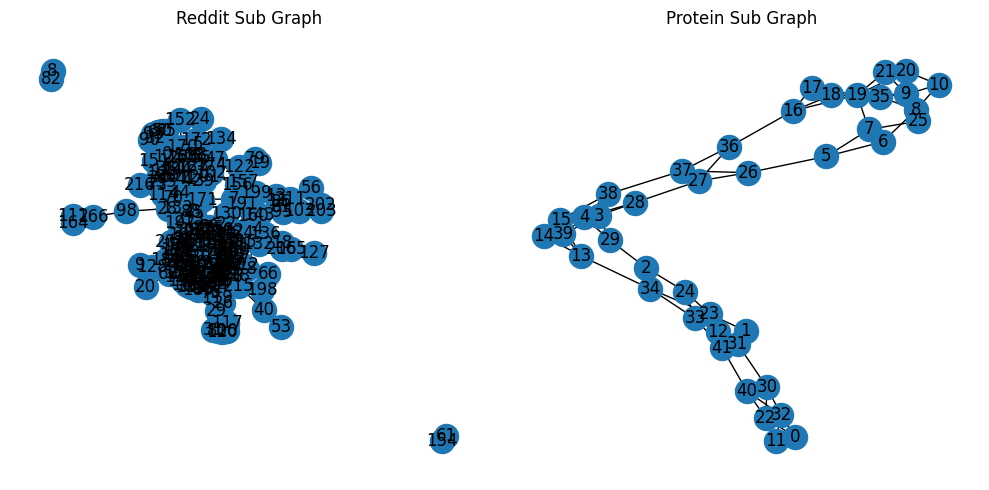

In [ ]:
# Create subgraphs and convert PyTorch Geometric graph to  NetworkX
sub_reddit_nx = nx.Graph()
sub_reddit_nx.add_edges_from(reddit_g[0].edge_index.t().numpy())

sub_proteins_nx = nx.Graph()
sub_proteins_nx.add_edges_from(proteins_g[0].edge_index.t().numpy())

# Visualize graphs
fig = plt.figure(figsize=(10, 5))
plt.subplot(121)
nx.draw(sub_reddit_nx, with_labels=True)
plt.title("Reddit Sub Graph")
plt.subplot(122)
nx.draw(sub_proteins_nx, with_labels=True)
plt.title("Protein Sub Graph")
plt.tight_layout()
plt.show()



Here is how the Weisfeiler-Lehhman Kernel was implemented:

In [ ]:
@profile
def wl_kernel(G1, G2, iterations):
    start_time = time.time()

    # initialize the first attribute
    initial_attribute = 1

    # Initialize node labels
    for G in [G1, G2]:
        nx.set_node_attributes(G, initial_attribute, "color")

    # Initialize the kernel vector
    kernel_vector_g1 = {}
    kernel_vector_g2 = {}

    kernel_vector_g1[initial_attribute] = G1.number_of_nodes()
    kernel_vector_g2[initial_attribute] = G2.number_of_nodes()

    # Get colors
    for _ in range(iterations):
        G1_labels, G1_color_map = get_labels(G1)
        G2_labels, G2_color_map = get_labels(G2)

        labels = set(G1_labels) | set(G2_labels)

        for label in labels:
            kernel_vector_g1[label] = G1_labels[label] if label in G1_labels else 0
            kernel_vector_g2[label] = G2_labels[label] if label in G2_labels else 0

        nx.set_node_attributes(G1, G1_color_map, "color")
        nx.set_node_attributes(G2, G2_color_map, "color")

    # Convert the kernel dictionary into a vector

    vector_g1 = np.array([i for i in kernel_vector_g1.values() ])
    vector_g2 = np.array([i for i in kernel_vector_g2.values() ])

    # Normalize vectors before dot product to prevent overflow
    vector_g1_norm = vector_g1 / np.linalg.norm(vector_g1)
    vector_g2_norm = vector_g2 / np.linalg.norm(vector_g2)

    # Return the normalized value
    result = np.dot(vector_g1_norm, vector_g2_norm)


    # Compute and Format time execution
    end_time = time.time()
    execution_time = end_time - start_time

    return result, execution_time


def get_labels(G):
    color = []
    color_map = {}

    for node in G.nodes():
      # Get the current color
      current_label = str(G.nodes[node]["color"])
      # Get neighbours' color and sort them
      neighbor_labels = sorted([G.nodes[neighbor]["color"] for neighbor in G.neighbors(node)])
      # Join the colors
      color_string = current_label + "".join([str(i) for i in neighbor_labels])
      # Hash the new color
      new_label = hash(color_string)
      color.append(new_label)
      color_map[node] = new_label

    color_count = Counter(color)

    return color_count, color_map



Let's apply the algorithm to TUDataset and see the results:

In [ ]:
iterations = 4
# Compute Weisfeiler-Lehman kernel
wsl_kernel_sim, computation_cost, memory = wl_kernel(reddit_nx,proteins_nx,iterations)

# Print the comparision table
update_table([["Weisfeiler-Lehman kernel", wsl_kernel_sim, computation_cost,memory, iterations  ]], ["normalize similarity", "time (s)","memory usage", "#iterations" ])




╒══════════════════════════╤════════════════════════╤════════════╤════════════════╤═══════════════╕
│                          │   normalize similarity │   time (s) │   memory usage │   #iterations │
╞══════════════════════════╪════════════════════════╪════════════╪════════════════╪═══════════════╡
│ Weisfeiler-Lehman kernel │               0.762525 │    25.2418 │         39.875 │             4 │
╘══════════════════════════╧════════════════════════╧════════════╧════════════════╧═══════════════╛


We can now compare the accuracy and computational cost of the Graphlet Kernel and Weisfeiler-Lehman (WL) Graph Kernel algorithms. Given that the former approach is time-intensive, we will evaluate the differences between the two algorithms using a subset of the TUDatasets (400 nodes).



In [ ]:
iterations = 4

# Apply the Weisfeiler-Lehman kernel
kernel_sim, wl_execution_time, wl_memory_consumption = wl_kernel(sub_reddit_nx,sub_proteins_nx,iterations)

# Apply the Graphlet algorithm
graphlet_sim, gl_execution_time, gl_memory_consumption = graphlet_kernel( sub_reddit_nx,sub_proteins_nx,iterations)

# Show Results
update_table([["Weisfeiler-Lehman kernel", kernel_sim, wl_execution_time,wl_memory_consumption, iterations  ],["Graphlet kernel", graphlet_sim, gl_execution_time,gl_memory_consumption, iterations  ]], ["normalize similarity", "time (s)","memory usage", "#iterations" ])


╒══════════════════════════╤════════════════════════╤═══════════════╤════════════════╤═══════════════╕
│                          │   normalize similarity │      time (s) │   memory usage │   #iterations │
╞══════════════════════════╪════════════════════════╪═══════════════╪════════════════╪═══════════════╡
│ Weisfeiler-Lehman kernel │               0.572599 │    0.00729036 │        0       │             4 │
├──────────────────────────┼────────────────────────┼───────────────┼────────────────┼───────────────┤
│ Graphlet kernel          │               0.525015 │ 1740.5        │        1.28906 │             4 │
╘══════════════════════════╧════════════════════════╧═══════════════╧════════════════╧═══════════════╛


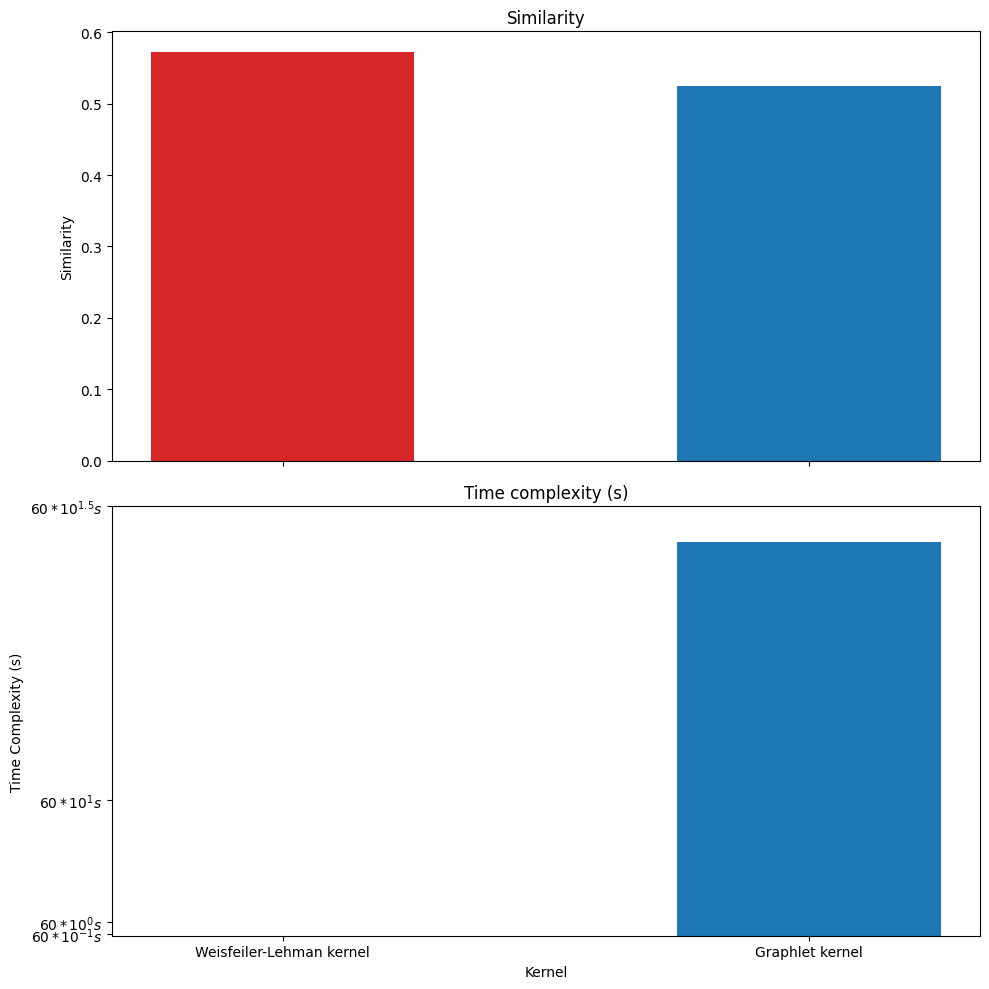

In [ ]:
names = ["Weisfeiler-Lehman kernel", "Graphlet kernel"]
bar_colors = ['tab:red', 'tab:blue']
sim_values = [kernel_sim, graphlet_sim]
time_values = [wl_execution_time, gl_execution_time]

fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(10, 10), sharex=True, tight_layout=True)
ax1.bar(names, sim_values, color=bar_colors, width=0.5)
ax3.bar(names, time_values, color=bar_colors, width=0.5)

ax1.set_title("Similarity")
ax3.set_title("Time complexity (s)")

ax1.set_ylabel('Similarity')
ax3.set_ylabel('Time Complexity (s)')
ax3.set_xlabel('Kernel')

ax3.set_yticks([ 60*10**-1, 60*10**0, 60*10**1,60*10**1.5], ['$60*10^{-1} s$','$60*10^{0} s$', '$60*10^{1} s$', '$60*10^{1.5} s$'])





plt.show()



# 3. Experimentation and Analysis




In this final section, we will evaluate the efficiency of the Weisfeiler-Lehman (WL) Graph Kernel by varying the number of
$K\text{-hops}$ and increasing the graph size (number of nodes). We will analyze the impact of these changes on similarity, time complexity, and memory consumption.

We first consider the number of
$K\text{-hops}$, selecting seven different sizes ranging from 3 to 100. The results are plotted in the figure below.

In [ ]:
iterations_number = [3, 5, 10, 20, 50,70,100]
x = np.array(iterations_number)
time_complexity = []
memory_usage = []
similarity = []

for i in iterations_number:
  print(f"We are at iteration {i}")
  sim, computation_cost, memory = wl_kernel(reddit_nx, proteins_nx, i)
  similarity.append(sim)
  time_complexity.append(computation_cost)
  memory_usage.append(memory)



time_complexity = np.array(time_complexity)
sim = np.array(similarity)
memory_usage = np.array(memory_usage)




We are at iteration 3
We are at iteration 5
We are at iteration 10
We are at iteration 20
We are at iteration 50
We are at iteration 70
We are at iteration 100


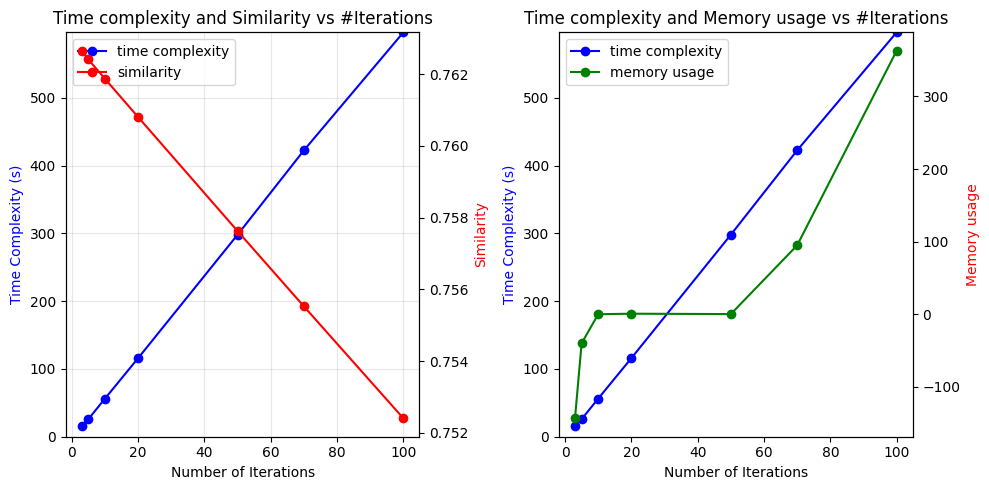

In [ ]:

# Set figure
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(10, 5))

# First graph
ax2 = ax1.twinx()
line1, =ax1.plot(x, time_complexity, color='blue', marker='o', label = "time complexity")
line2, = ax2.plot(x, sim, color='red', marker='o', label = "similarity")

# Set axis
ax1.set_ylim(0, max(time_complexity))
ax1.set_xlabel('Number of Iterations')
ax1.set_ylabel('Time Complexity (s)', color='blue')
ax2.set_ylabel('Similarity', color='red')

# Set legends
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')
ax1.title.set_text('Time complexity and Similarity vs #Iterations')


# Second graph
ax4 = ax3.twinx()
line3, = ax3.plot(x, time_complexity, color='blue', marker='o', label = "time complexity")
line4, = ax4.plot(x, memory_usage, color='green', marker='o', label = "memory usage")

ax3.set_ylim(0, max(time_complexity))
ax3.set_xlabel('Number of Iterations')
ax3.set_ylabel('Time Complexity (s)', color='blue')
ax4.set_ylabel('Memory usage', color='red')

lines = [line3, line4]
labels = [line.get_label() for line in lines]
ax3.legend(lines, labels, loc='upper left')
ax3.title.set_text('Time complexity and Memory usage vs #Iterations')



# Set grid
fig.tight_layout()
ax1.grid(True, alpha=0.3)

plt.show()

Finally, we will evaluate the efficiency of the algorithm by increasing the number of nodes. As before, we have selected seven different sizes, ranging from 200 to 20,000 nodes. To facilitate this, we will sample nodes from the TUDataset without replacement.

In [ ]:
import random

number_of_nodes = [100, 500, 1000, 2500,5000, 10000,20000]
x = np.array(number_of_nodes)
time_complexity = []
memory_usage = []
similarity = []




for i in number_of_nodes:
  # Select a random subset of nodes from reddit_nx
  selected_reddit_nodes = random.sample(list(reddit_nx.nodes()), i)
  reddit_subgraph = reddit_nx.subgraph(selected_reddit_nodes)

  # Select a random subset of nodes from proteins_nx
  selected_proteins_nodes = random.sample(list(proteins_nx.nodes()), i)
  proteins_subgraph = proteins_nx.subgraph(selected_proteins_nodes)

  sim, computation_cost, memory = wl_kernel(reddit_subgraph, proteins_subgraph, 100)
  similarity.append(sim)
  time_complexity.append(computation_cost)
  memory_usage.append(memory)



time_complexity = np.array(time_complexity)
sim = np.array(similarity)
memory_usage = np.array(memory_usage)

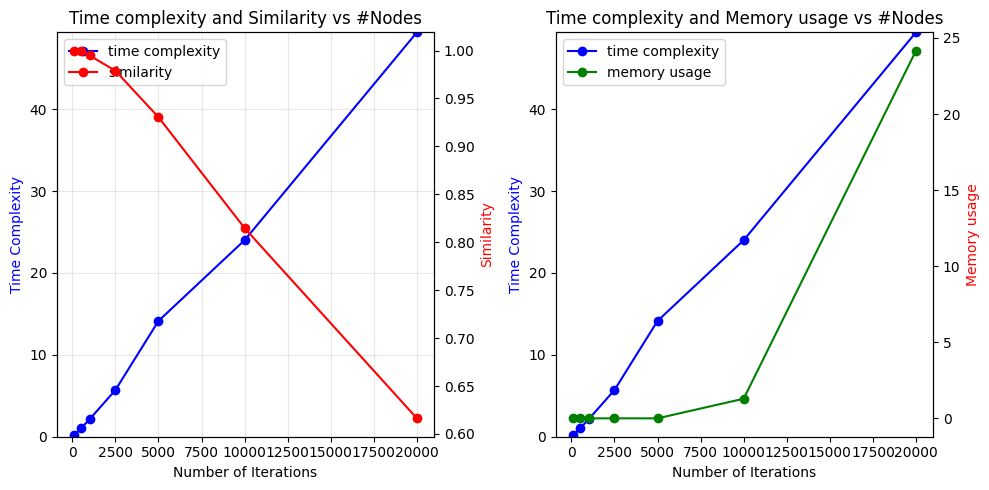

In [ ]:
# Set figure
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(10, 5))



# First graph
ax2 = ax1.twinx()
line1, =ax1.plot(x, time_complexity, color='blue', marker='o', label = "time complexity")
line2, = ax2.plot(x, sim, color='red', marker='o', label = "similarity")

# Set axis
ax1.set_ylim(0, max(time_complexity))
ax1.set_xlabel('Number of Iterations')
ax1.set_ylabel('Time Complexity', color='blue')
ax2.set_ylabel('Similarity', color='red')

# Legends

lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')
ax1.title.set_text('Time complexity and Similarity vs #Nodes')


# Second graph
ax4 = ax3.twinx()
line3, = ax3.plot(x, time_complexity, color='blue', marker='o', label = "time complexity")
line4, = ax4.plot(x, memory_usage, color='green', marker='o', label = "memory usage")

ax3.set_ylim(0, max(time_complexity))
ax3.set_xlabel('Number of Iterations')
ax3.set_ylabel('Time Complexity', color='blue')
ax4.set_ylabel('Memory usage', color='red')

lines = [line3, line4]
labels = [line.get_label() for line in lines]
ax3.legend(lines, labels, loc='upper left')
ax3.title.set_text('Time complexity and Memory usage vs #Nodes')



# Set grid
fig.tight_layout()
ax1.grid(True, alpha=0.3)

plt.show()
